In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

['2017-08-23']
2016-08-23


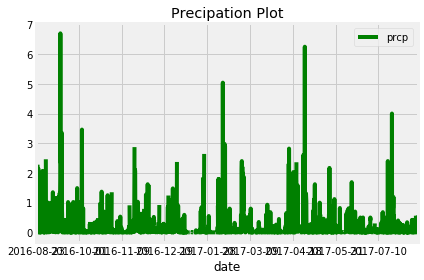

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_date = np.ravel(session.query(func.strftime('%Y-%m-%d', Measurement.date)).order_by(Measurement.date.desc()).first())
print(latest_date) 

# Calculate the date 1 year ago from the last data point in the database
start_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(start_date)

# Perform a query to retrieve the data and precipitation scores
prcp_scores = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date >= start_date).all() 

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(prcp_scores)
df.set_index("date", inplace=True)

# Sort the dataframe by date
df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(color='green', title="Precipation Plot")
plt.tight_layout()
plt.savefig("Images/precipation_plot.png")
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.id).count()
stations

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active = active_stations[0][0]
stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
        filter(Measurement.station == most_active).all()
        
stats

[(54.0, 85.0, 71.66378066378067)]

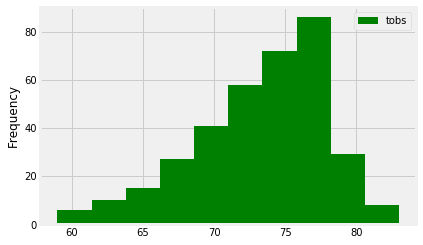

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_12_M = session.query(Measurement.date, Measurement.tobs).\
            filter(Measurement.date >= start_date).\
            filter(Measurement.station == most_active).all() 
stat_temp_12_M = pd.DataFrame(temp_12_M)
stat_temp_12_M.set_index("date", inplace=True)
stat_temp_12_M.sort_values("date", inplace=True)
stat_temp_12_M

stat_temp_12_M.plot(kind='hist', color='green')
plt.savefig('Images/temp_histogram')
plt.show()

In [16]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [17]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start_date = "2017-01-01"
trip_end_date = "2017-01-15"
print((calc_temps(trip_start_date, trip_end_date)))
val = (calc_temps(trip_start_date, trip_end_date))
#avg = avg[0][1] 
#avg

[(60.0, 68.5505617977528, 81.0)]


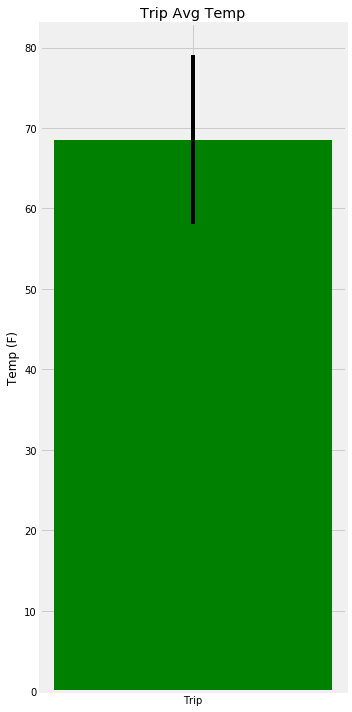

In [18]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

tavg = val[0][1]
tmax = val[0][2]
tmin = val[0][0]
err = (tmax - tmin) / 2

plt.figure(figsize=(5,10))
plt.bar("Trip", tavg, yerr=err, width = 0.1, color='green')
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.savefig("Images/trip_bar.png")
plt.show()

In [19]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

total_rainfall = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, 
                               Station.elevation, func.sum(Measurement.prcp)).\
                                filter(Measurement.station == Station.station).\
                                filter(Measurement.date >= trip_start_date).\
                                filter(Measurement.date <= trip_end_date).\
                                group_by(Measurement.station).\
                                order_by(func.sum(Measurement.prcp).desc()).all()
total_rainfall                

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.64),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.63),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.61),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.35),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.21000000000000002),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

## Optional Challenge Assignment

In [20]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [21]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start_date = dt.date(2017,1,1)
trip_end_date = dt.date(2017,1,15)

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date

normal_trip_start_date = dt.datetime.strftime(trip_start_date, "%m-%d")
normal_trip_end_date = dt.datetime.strftime(trip_end_date, "%m-%d")

trip_date = []
normals = []

#https://stackoverflow.com/questions/1060279/iterating-through-a-range-of-dates-in-python
daterange = pd.date_range(trip_start_date, trip_end_date)

for single_date in daterange:
    date = single_date.strftime("%Y-%m-%d")
    trip_date.append(date) 

#same loop above just modifed dateformat to call the function
for date in daterange:
    date = date.strftime("%m-%d")
    normal = np.ravel(daily_normals(date))
    normals.append(normal)
print(trip_date, normals)


['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12', '2017-01-13', '2017-01-14', '2017-01-15'] [array([62.        , 69.15384615, 77.        ]), array([60.        , 69.39622642, 77.        ]), array([62.        , 68.90909091, 77.        ]), array([58., 70., 76.]), array([56.        , 67.96428571, 76.        ]), array([61.        , 68.96491228, 76.        ]), array([57.        , 68.54385965, 76.        ]), array([57.        , 67.16071429, 75.        ]), array([58.        , 67.92982456, 78.        ]), array([62.        , 69.74137931, 77.        ]), array([57.        , 67.31034483, 78.        ]), array([57.        , 67.40740741, 81.        ]), array([57.        , 67.25454545, 77.        ]), array([58.        , 69.52631579, 77.        ]), array([56.        , 69.31372549, 78.        ])]


In [22]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_normal = pd.DataFrame(normals).rename(columns={0: "TMin", 1:"TMax", 2:"TAvg"})
df_normal["Date"] = trip_date
df_normal.set_index("Date", inplace=True)
df_normal

,TMin,TMax,TAvg
Date,,,
2017-01-01,62.0,69.153846,77.0
2017-01-02,60.0,69.396226,77.0
2017-01-03,62.0,68.909091,77.0
2017-01-04,58.0,70.000000,76.0
2017-01-05,56.0,67.964286,76.0
2017-01-06,61.0,68.964912,76.0
2017-01-07,57.0,68.543860,76.0
2017-01-08,57.0,67.160714,75.0
2017-01-09,58.0,67.929825,78.0


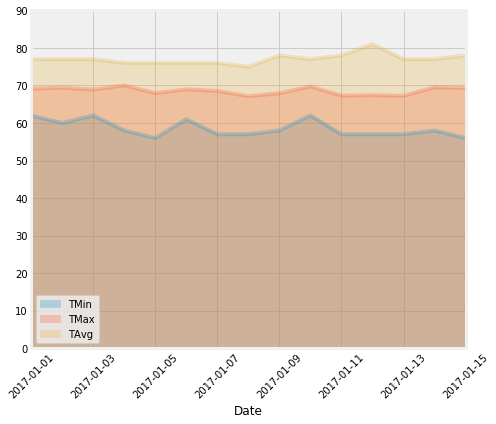

In [86]:
# Plot the daily normals as an area plot with `stacked=False`
df_normal.plot.area(stacked=False, figsize=(7,6), alpha=0.25)
plt.xticks(rotation=45)
plt.ylim(0, 90) 
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('Images/Area_Plot.png')